# CS235 Fall 2024 Course Project

Name: Joshua Pulido, Allan Peh

Student ID: 862476702, 862007781

## Introduction
In this project, a number of data
mining techniques that we cover in this class will be implemented and applied to a real-world imbalanced
dataset.

**Dataset:** Wisconsin Breast Cancer Diagnostic dataset from the UCI data repository: https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic

In [60]:
%matplotlib inline


import itertools, collections
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, make_scorer
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from ucimlrepo import fetch_ucirepo



In [156]:
# fetch dataset 
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 

# data (as pandas dataframes) 
X = breast_cancer_wisconsin_diagnostic.data.features 

# # Metadata
# print(breast_cancer_wisconsin_diagnostic.metadata)

X

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


## Q1 - KMeans clustering and KMeans++

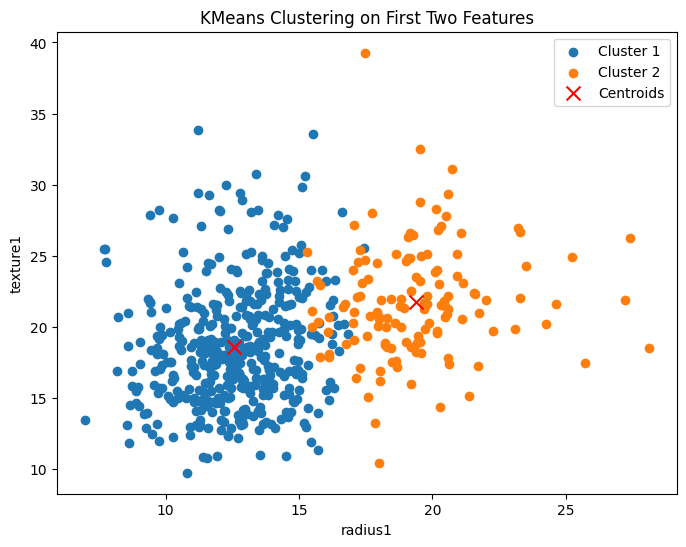

In [300]:
class KMEANS:
    def __init__(self, n_clusters = 3, kmeans_type='random', max_iterations=100):
        self.n_clusters = n_clusters
        self.max_iterations = max_iterations
        self.kmeans_type = kmeans_type

    def e_distance(self, a, b):
        return np.sqrt(np.sum((a - b) ** 2))
    
    def centroid_init(self, data):
        if self.kmeans_type == 'random':
            indices = np.random.choice(data.shape[0], self.n_clusters, replace=False)
            return data[indices]
        if self.kmeans_type == 'Kmeans++':
            # Initialize centroids with one random point
            centroids = [data[np.random.randint(data.shape[0])]]
            for _ in range(1, self.n_clusters):
                # Calculate squared distances from data points to existing centroids
                min_sq_dist = [
                    min([self.e_distance(c, x) ** 2 for c in centroids]) 
                    for x in data
                ]
                prob = min_sq_dist / np.sum(min_sq_dist)
                # Select the next centroid randomly based on the probability distribution
                next_centroid = data[np.random.choice(range(len(data)), size=1, p=prob)]
                centroids.append(next_centroid[0])  # Append the next centroid
            return np.array(centroids)

                    
    def fit(self, data):
        self.centroids = self.centroid_init(data)
        
        for iteration in range(self.max_iterations):
            clusters = [[] for _ in range(self.n_clusters)]  # Initialize empty clusters
            for point in data:
                distances = [self.e_distance(point, centroid) for centroid in self.centroids]
                closest_centroid_idx = np.argmin(distances)  # Find the closest centroid
                clusters[closest_centroid_idx].append(point)  # Assign the point to the closest centroid's cluster

            # Step 4: Update centroids by calculating the mean of each cluster
            new_centroids = np.array([
                np.mean(cluster, axis=0) if cluster else self.centroids[i]  # Avoid NaN if no points assigned to a cluster
                for i, cluster in enumerate(clusters)
            ])

            # Step 5: Check for convergence (if centroids do not change)
            self.centroids = new_centroids  # Update centroids for the next iteration

        self.clusters = clusters
        
    def predict(self, data):
        # Assign each data point to the nearest centroid
        labels = []
        for point in data:
            distances = [self.e_distance(point, centroid) for centroid in self.centroids]
            closest_centroid_idx = np.argmin(distances)
            labels.append(closest_centroid_idx)
        return np.array(labels)
        
    def plot(self, data):
        for i, cluster in enumerate(self.clusters):
            cluster = np.array(cluster)
            plt.scatter(cluster[:, 0], cluster[:, 1], label=f'Cluster {i+1}')
        plt.scatter(self.centroids[:, 0], self.centroids[:, 1], c='red', marker='x', s=100, label='Centroids')
        plt.legend()
            

scaler = StandardScaler()
X_array = np.array(X)
# Fit and transform the data
scaled_data = scaler.fit_transform(X)

# Fit the model using the first two features for 2D visualization
kmeans = KMEANS(n_clusters=2, kmeans_type='random', max_iterations=100)
kmeans.fit(X_array) 

plt.figure(figsize=(8, 6))
kmeans.plot(X_array)  
plt.xlabel("radius1")
plt.ylabel("texture1")
plt.title("KMeans Clustering on First Two Features")
plt.show()
            
            

In [308]:
from sklearn.metrics import silhouette_score

kmeans_2 = KMEANS(n_clusters=2, max_iterations=100, kmeans_type='random')
kmeans_3 = KMEANS(n_clusters=3, max_iterations=100, kmeans_type='random')
kmeans_4 = KMEANS(n_clusters=4, max_iterations=100, kmeans_type='random')
kmeans_5 = KMEANS(n_clusters=5, max_iterations=100, kmeans_type='random')
kmeans_6 = KMEANS(n_clusters=6, max_iterations=100, kmeans_type='random')

kmeans_pp_2 = KMEANS(n_clusters=2, max_iterations=100, kmeans_type='Kmeans++')
kmeans_pp_3 = KMEANS(n_clusters=3, max_iterations=100, kmeans_type='Kmeans++')
kmeans_pp_4 = KMEANS(n_clusters=4, max_iterations=100, kmeans_type='Kmeans++')
kmeans_pp_5 = KMEANS(n_clusters=5, max_iterations=100, kmeans_type='Kmeans++')
kmeans_pp_6 = KMEANS(n_clusters=6, max_iterations=100, kmeans_type='Kmeans++')

kmeans_2.fit(X_array) 
kmeans_3.fit(X_array) 
kmeans_4.fit(X_array) 
kmeans_5.fit(X_array)
kmeans_6.fit(X_array) 

kmeans_pp_2.fit(X_array) 
kmeans_pp_3.fit(X_array) 
kmeans_pp_4.fit(X_array) 
kmeans_pp_5.fit(X_array) 
kmeans_pp_6.fit(X_array) 

# Step 2: Predict cluster labels
labels_2 = kmeans_2.predict(X_array)
labels_3 = kmeans_3.predict(X_array)
labels_4 = kmeans_4.predict(X_array)
labels_5 = kmeans_5.predict(X_array)
labels_6 = kmeans_6.predict(X_array)

labels_pp_2 = kmeans_pp_2.predict(X_array)
labels_pp_3 = kmeans_pp_3.predict(X_array)
labels_pp_4 = kmeans_pp_4.predict(X_array)
labels_pp_5 = kmeans_pp_5.predict(X_array)
labels_pp_6 = kmeans_pp_6.predict(X_array)

# Step 3: Compute silhouette score
sil_score_2 = silhouette_score(X_array, labels_2)
sil_score_3 = silhouette_score(X_array, labels_3)
sil_score_4 = silhouette_score(X_array, labels_4)
sil_score_5 = silhouette_score(X_array, labels_5)
sil_score_6 = silhouette_score(X_array, labels_6)

pp_sil_score_2 = silhouette_score(X_array, labels_pp_2)
pp_sil_score_3 = silhouette_score(X_array, labels_pp_3)
pp_sil_score_4 = silhouette_score(X_array, labels_pp_4)
pp_sil_score_5 = silhouette_score(X_array, labels_pp_5)
pp_sil_score_6 = silhouette_score(X_array, labels_pp_6)

print(f"Kmeans Silhouette Score k = 2: {sil_score_2:.3f}")
print(f"Kmeans Silhouette Score k = 3: {sil_score_3:.3f}")
print(f"Kmeans Silhouette Score k = 4: {sil_score_4:.3f}")
print(f"Kmeans Silhouette Score k = 5: {sil_score_5:.3f}")
print(f"Kmeans Silhouette Score k = 6: {sil_score_6:.3f}")

print(f"Kmeans++ Silhouette Score k = 2: {pp_sil_score_2:.3f}")
print(f"Kmeans++ Silhouette Score k = 3: {pp_sil_score_3:.3f}")
print(f"Kmeans++ Silhouette Score k = 4: {pp_sil_score_4:.3f}")
print(f"Kmeans++ Silhouette Score k = 5: {pp_sil_score_5:.3f}")
print(f"Kmeans++ Silhouette Score k = 6: {pp_sil_score_6:.3f}")



Kmeans Silhouette Score k = 2: 0.697
Kmeans Silhouette Score k = 3: 0.547
Kmeans Silhouette Score k = 4: 0.533
Kmeans Silhouette Score k = 5: 0.507
Kmeans Silhouette Score k = 6: 0.476
Kmeans++ Silhouette Score k = 2: 0.697
Kmeans++ Silhouette Score k = 3: 0.547
Kmeans++ Silhouette Score k = 4: 0.533
Kmeans++ Silhouette Score k = 5: 0.531
Kmeans++ Silhouette Score k = 6: 0.468


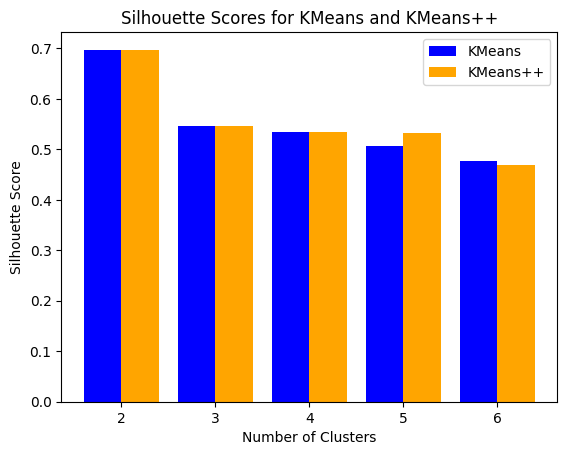

In [309]:
k_num = ['2', '3', '4', '5', '6']
kmeans_scores = [sil_score_2, sil_score_3, sil_score_4, sil_score_5, sil_score_6]
kmeans_pp_scores = [pp_sil_score_2, pp_sil_score_3, pp_sil_score_4, pp_sil_score_5, pp_sil_score_6]

# X-axis positions
x = np.arange(len(k_num))

# Plot
plt.bar(x - 0.2, kmeans_scores, width=0.4, label='KMeans', color='blue')
plt.bar(x + 0.2, kmeans_pp_scores, width=0.4, label='KMeans++', color='orange')

# Add labels, title, and legend
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for KMeans and KMeans++')
plt.xticks(x, k_num)
plt.legend()

# Show plot
plt.show()


## Q2 - DBSCAN

In [312]:
class DBSCAN:
    def __init__(self, eps=None, min_samples=None):
        self.eps = eps
        self.min_samples = min_samples
        self.labels_ = None

    def fit(self, X):
        n_samples = X.shape[0]
        self.labels_ = -1 * np.ones(n_samples)  
        cluster_id = 0

        for idx in range(n_samples):
            if self.labels_[idx] != -1:  
                continue

            # Find neighbors
            neighbors = self._region_query(X, idx)

            if len(neighbors) < self.min_samples:
                self.labels_[idx] = -1  
            else:
                cluster_id += 1
                self._grow_cluster(X, idx, neighbors, cluster_id)

    def _region_query(self, X, idx):
        neighbors = []
        for i in range(len(X)):
            if np.linalg.norm(X[idx] - X[i]) <= self.eps:
                neighbors.append(i)
        return neighbors

    def _grow_cluster(self, X, idx, neighbors, cluster_id):
        self.labels_[idx] = cluster_id
        i = 0
        while i < len(neighbors):
            neighbor_idx = neighbors[i]

            if self.labels_[neighbor_idx] == -1:  
                self.labels_[neighbor_idx] = cluster_id
            elif self.labels_[neighbor_idx] == -1:
                self.labels_[neighbor_idx] = cluster_id
                new_neighbors = self._region_query(X, neighbor_idx)
                if len(new_neighbors) >= self.min_samples:
                    neighbors += new_neighbors
            i += 1
    
    def predict(self):
        return self.labels_

In [314]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

eps = 0.1
min_samples = 5

# Apply dbscan
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan.fit(X_scaled)
labels = dbscan.predict()

for idx in range(X_scaled.shape[0]):
    neighbors = []
    neighbor_dists = {}
    for i in range(X_scaled.shape[0]):
        euc_dist = np.linalg.norm(X_scaled[idx] - X_scaled[i])
        if euc_dist <= eps:
            neighbors.append(i)
            neighbor_dists[i] = euc_dist
    if len(neighbors) >= min_samples:
        print(idx,neighbors)
        print(idx,neighbor_dists.values(),'\n')

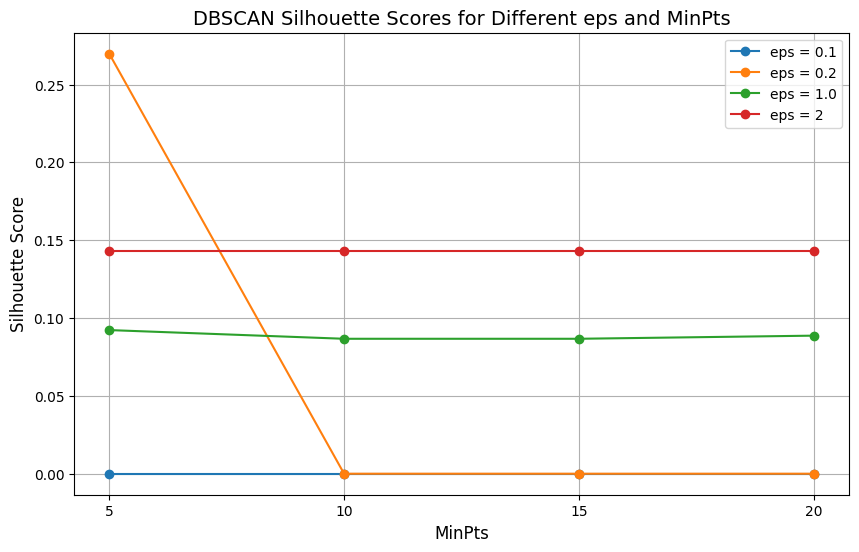

In [315]:

# parameters
eps_values = [0.1, 0.2, 1.0, 2]
min_samples_values = [5, 10, 15, 20]
results = {}

# Evaluate DBSCAN at diff eps value and MinPts
for eps in eps_values:
    silhouette_scores = []
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(X_scaled)
        labels = dbscan.predict()

        # filtering noise 
        valid_indices = labels != -1
        if len(set(labels[valid_indices])) > 1: 
            score = silhouette_score(X_scaled[valid_indices], labels[valid_indices])
        else:
            score = 0
        silhouette_scores.append(score)
    results[eps] = silhouette_scores

# Plot the results
plt.figure(figsize=(10, 6))
for eps, scores in results.items():
    plt.plot(min_samples_values, scores, label=f'eps = {eps}', marker='o')

plt.title('DBSCAN Silhouette Scores for Different eps and MinPts', fontsize=14)
plt.xlabel('MinPts', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.xticks(min_samples_values)
plt.legend()
plt.grid()
plt.show()


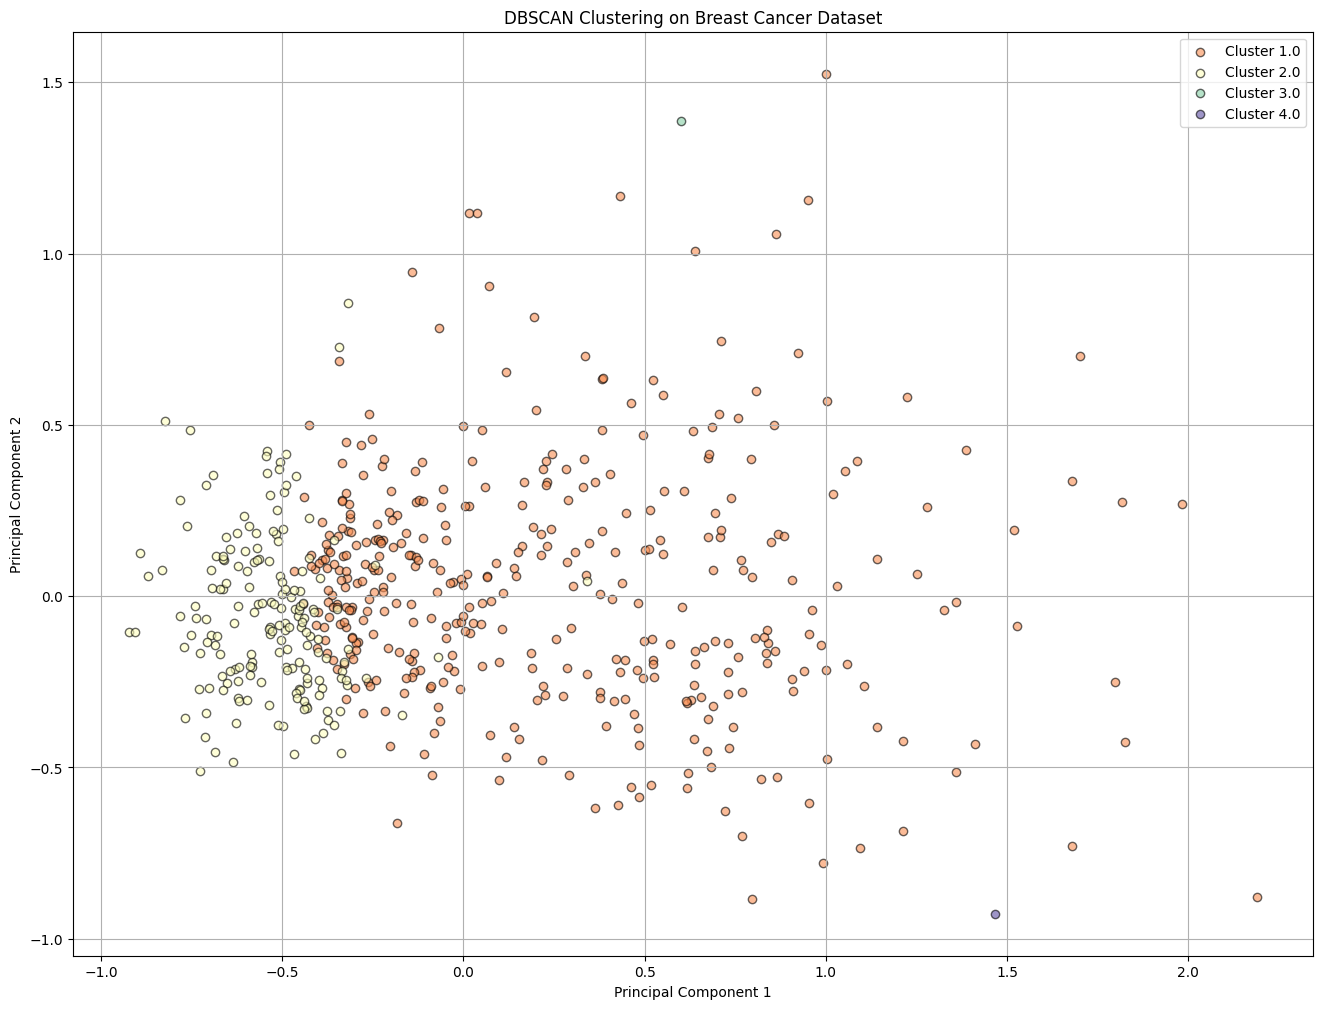

In [316]:
from sklearn.decomposition import PCA

# Reduce the dataset to 2D 
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot the clusters
unique_labels = set(labels)
plt.figure(figsize=(16, 12))

for label in unique_labels:
    if label == -1:
        color = 'k'
        label_name = 'Noise'
    else:
        color = plt.cm.Spectral(label / len(unique_labels))
        label_name = f'Cluster {label}'
    plt.scatter(
        X_pca[np.array(labels) == label, 0],
        X_pca[np.array(labels) == label, 1],
        c=[color],
        label=label_name,
        alpha=0.6,
        edgecolors='k'
    )

plt.title('DBSCAN Clustering on Breast Cancer Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid()
plt.show()

## Q3 - Spectral Clustering

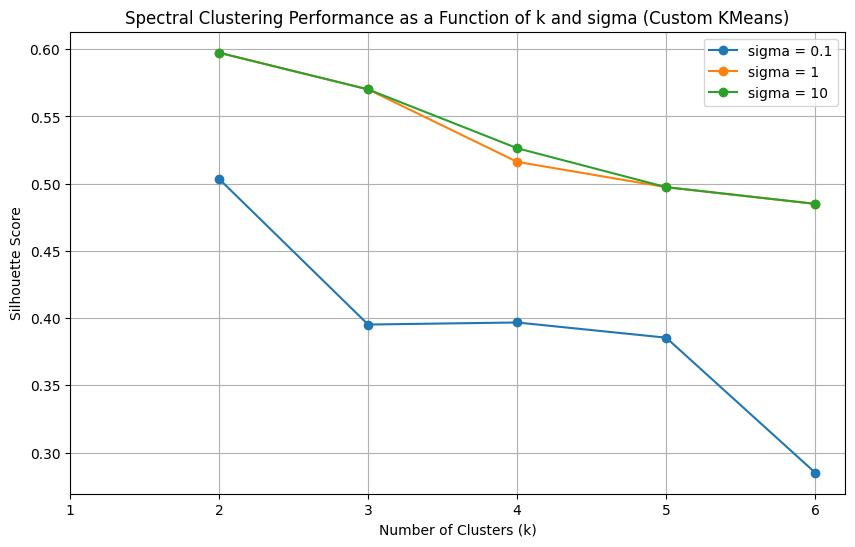

In [317]:
from scipy.spatial.distance import cdist


def construct_similarity_graph(X, sigma):
    distances = cdist(X, X, metric="euclidean")
    W = np.exp(-distances ** 2 / (2 * sigma ** 2))
    np.fill_diagonal(W, 0)  # No self-loops
    return W

# Unnormalized Laplacian
def compute_unnormalized_laplacian(W):
    """
    D = degree matrix
    L = Lapclan matrix graph
    W = Adj matrix
    """
    D = np.diag(np.sum(W, axis=1))  
    L = D - W
    return L


# Spectral Clustering with my KMeans
def unnormalized_spectral_clustering(X, n_clusters, sigma):
    # Construct the similarity graph
    W = construct_similarity_graph(X, sigma)

    #unnormalized Laplacian
    L = compute_unnormalized_laplacian(W)

    # eigenvalues and eigenvectors of the Laplacian
    eigenvalues, eigenvectors = np.linalg.eigh(L)

    X_spectral = eigenvectors[:, :n_clusters]

    # Applying my KMeans to the eigenvector matrix
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X_spectral)

    return kmeans.predict(X_spectral)



sigma_values = [0.1, 1, 10]
k_values = range(1, 7)  
results = {sigma: [] for sigma in sigma_values}

for sigma in sigma_values:
    for k in k_values:
        labels = unnormalized_spectral_clustering(X_scaled, n_clusters=k, sigma=sigma)

        # Compute Silhouette Score for performance evaluation
        #setting up condition for k
        if k > 1:  
            from sklearn.metrics import silhouette_score
            sil_score = silhouette_score(X_scaled, labels)
            results[sigma].append(sil_score)
        else:
            results[sigma].append(None)

# Plot the results
plt.figure(figsize=(10, 6))

for sigma in sigma_values:
    plt.plot(
        k_values,
        results[sigma],
        marker='o',
        label=f'sigma = {sigma}'
    )

plt.title('Spectral Clustering Performance as a Function of k and sigma (Custom KMeans)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.legend()
plt.grid()
plt.show()

## Q4 - Isolation Forest

Silhouette Score: 0.5888365211705185


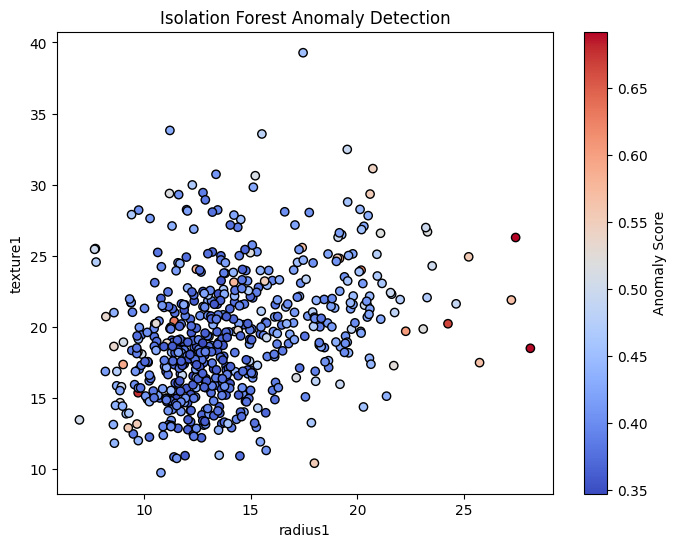

In [296]:
import numpy as np

# Algorithm 1: iForest
class IsolationTree:
    def __init__(self, height_limit):
        self.height_limit = height_limit
        self.tree = None

    def fit(self, X, current_height=0):
        return self._iTree(X, current_height, self.height_limit)

    def _iTree(self, X, e, l):
        if e >= l or len(X) <= 1:
            # External node (exNode)
            return {"is_leaf": True, "size": len(X)}

        # Randomly select a feature and split value
        q = np.random.randint(0, X.shape[1])  # Random attribute
        p = np.random.uniform(X[:, q].min(), X[:, q].max())  # Random split point

        # Split data
        Xl = X[X[:, q] < p]
        Xr = X[X[:, q] >= p]

        # Internal node (inNode)
        return {
            "is_leaf": False,
            "left": self._iTree(Xl, e + 1, l),
            "right": self._iTree(Xr, e + 1, l),
            "split_att": q,
            "split_val": p
        }

    def path_length(self, x, node=None, current_length=0):
        if node is None:
            node = self.tree

        if node["is_leaf"]:
            return current_length + c_factor(node["size"])  # Path length adjustment

        # Traverse left or right based on the split condition
        if x[node["split_att"]] < node["split_val"]:
            return self.path_length(x, node["left"], current_length + 1)
        else:
            return self.path_length(x, node["right"], current_length + 1)


class IsolationForest:
    def __init__(self, n_trees=100, subsample_size=256, random_seed=None):
        self.n_trees = n_trees
        self.subsample_size = subsample_size
        self.trees = []
        if random_seed:
            np.random.seed(random_seed)

    def fit(self, X):
        self.trees = []
        height_limit = int(np.ceil(np.log2(self.subsample_size)))

        for _ in range(self.n_trees):
            # Subsample the data
            subsample_idx = np.random.choice(len(X), self.subsample_size, replace=False)
            X0 = X[subsample_idx]

            # Fit an isolation tree
            tree = IsolationTree(height_limit)
            tree.tree = tree.fit(X0)
            self.trees.append(tree)

    def path_length(self, x):
        # Calculate average path length for a single instance across all trees
        return np.mean([tree.path_length(x) for tree in self.trees])

    def anomaly_score(self, X):
        # Compute path lengths for all data points
        path_lengths = np.array([self.path_length(x) for x in X])
        # Convert path lengths to anomaly scores
        scores = 2 ** (-path_lengths / c_factor(len(X)))
        return scores

    def predict(self, X, threshold=0.5):
        # Predict anomalies: 1 for anomaly, 0 for normal
        scores = self.anomaly_score(X)
        return (scores > threshold).astype(int)


def c_factor(n):
    if n <= 1:
        return 0
    return 2 * (np.log(n - 1) + 0.5772156649) - (2 * (n - 1) / n)


iforest = IsolationForest(n_trees=200, subsample_size=512, random_seed=42)
iforest.fit(X_array)

# Predict cluster labels
predictions = iforest.predict(X_array, threshold=0.6)  

# Silhouette score
silhouette = silhouette_score(X_array, predictions)
print(f"Silhouette Score: {silhouette}")

feature_names = X.columns
x_label = feature_names[0]  # Feature for the x-axis
y_label = feature_names[1] 
    
# Visualize results
plt.figure(figsize=(8, 6))
plt.scatter(X_array[:, 0], X_array[:, 1], c=scores, cmap="coolwarm", edgecolor='k')
plt.colorbar(label="Anomaly Score")
plt.title("Isolation Forest Anomaly Detection")
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.show()

    

Kmeans Silhouette Score 99%: 0.329
Kmeans Silhouette Score 95%: 0.619
Kmeans Silhouette Score 90%: 0.629
Kmeans Silhouette Score 85%: 0.626
Kmeans++ Silhouette Score 99%: 0.329
Kmeans++ Silhouette Score 95%: 0.619
Kmeans++ Silhouette Score 90%: 0.629
Kmeans++ Silhouette Score 85%: 0.626


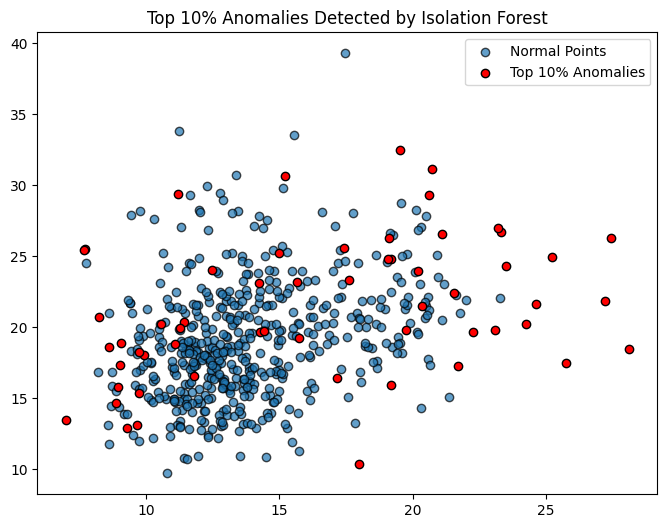

In [301]:
import numpy as np

# Instantiate and fit the IsolationForest
iso_forest = IsolationForest(n_trees=200, subsample_size=516, random_seed=42)
iso_forest.fit(X_array)

# Step 1: Compute anomaly scores
scores = iso_forest.anomaly_score(X_array)

# Step 2: Determine the top 1% threshold
threshold_99 = np.percentile(scores, 99)
threshold_95 = np.percentile(scores, 95)
threshold_90 = np.percentile(scores, 90)
threshold_85 = np.percentile(scores, 85)

# Step 3: Find the top 1% anomalies
top_1_percent_anomalies = X_array[scores > threshold_99]
top_5_percent_anomalies = X_array[scores > threshold_95]
top_10_percent_anomalies = X_array[scores > threshold_90]
top_15_percent_anomalies = X_array[scores > threshold_85]

normal_points_99 = X_array[scores <= threshold_99]
normal_points_95 = X_array[scores <= threshold_95]
normal_points_90 = X_array[scores <= threshold_90]
normal_points_85 = X_array[scores <= threshold_85]

kmeans_random_99 = KMEANS(n_clusters=2, max_iterations=100, kmeans_type='random')
kmeans_random_95 = KMEANS(n_clusters=2, max_iterations=100, kmeans_type='random')
kmeans_random_90 = KMEANS(n_clusters=2, max_iterations=100, kmeans_type='random')
kmeans_random_85 = KMEANS(n_clusters=2, max_iterations=100, kmeans_type='random')

kmeans_pp_99 = KMEANS(n_clusters=2, max_iterations=100, kmeans_type='Kmeans++')
kmeans_pp_95 = KMEANS(n_clusters=2, max_iterations=100, kmeans_type='Kmeans++')
kmeans_pp_90 = KMEANS(n_clusters=2, max_iterations=100, kmeans_type='Kmeans++')
kmeans_pp_85 = KMEANS(n_clusters=2, max_iterations=100, kmeans_type='Kmeans++')

kmeans_random_99.fit(top_1_percent_anomalies)
kmeans_random_95.fit(top_5_percent_anomalies)
kmeans_random_90.fit(top_10_percent_anomalies)
kmeans_random_85.fit(top_15_percent_anomalies)

kmeans_pp_99.fit(top_1_percent_anomalies)
kmeans_pp_95.fit(top_5_percent_anomalies)
kmeans_pp_90.fit(top_10_percent_anomalies)
kmeans_pp_85.fit(top_15_percent_anomalies)

# Step 2: Predict cluster labels
rand_labels_99 = kmeans_random_99.predict(top_1_percent_anomalies)
rand_labels_95 = kmeans_random_95.predict(top_5_percent_anomalies)
rand_labels_90 = kmeans_random_90.predict(top_10_percent_anomalies)
rand_labels_85 = kmeans_random_85.predict(top_15_percent_anomalies)

pp_labels_99 = kmeans_pp_99.predict(top_1_percent_anomalies)
pp_labels_95 = kmeans_pp_95.predict(top_5_percent_anomalies)
pp_labels_90 = kmeans_pp_90.predict(top_10_percent_anomalies)
pp_labels_85 = kmeans_pp_85.predict(top_15_percent_anomalies)

# Step 3: Compute silhouette score
rand_sil_score_99 = silhouette_score(top_1_percent_anomalies, rand_labels_99)
rand_sil_score_95 = silhouette_score(top_5_percent_anomalies, rand_labels_95)
rand_sil_score_90 = silhouette_score(top_10_percent_anomalies, rand_labels_90)
rand_sil_score_85 = silhouette_score(top_15_percent_anomalies, rand_labels_85)

pp_sil_score_99 = silhouette_score(top_1_percent_anomalies, pp_labels_99)
pp_sil_score_95 = silhouette_score(top_5_percent_anomalies, pp_labels_95)
pp_sil_score_90 = silhouette_score(top_10_percent_anomalies, pp_labels_90)
pp_sil_score_85 = silhouette_score(top_15_percent_anomalies, pp_labels_85)

print(f"Kmeans Silhouette Score 99%: {rand_sil_score_99:.3f}")
print(f"Kmeans Silhouette Score 95%: {rand_sil_score_95:.3f}")
print(f"Kmeans Silhouette Score 90%: {rand_sil_score_90:.3f}")
print(f"Kmeans Silhouette Score 85%: {rand_sil_score_85:.3f}")

print(f"Kmeans++ Silhouette Score 99%: {pp_sil_score_99:.3f}")
print(f"Kmeans++ Silhouette Score 95%: {pp_sil_score_95:.3f}")
print(f"Kmeans++ Silhouette Score 90%: {pp_sil_score_90:.3f}")
print(f"Kmeans++ Silhouette Score 85%: {pp_sil_score_85:.3f}")

plt.figure(figsize=(8, 6))
plt.scatter(normal_points_90[:, 0], normal_points_90[:, 1], label="Normal Points", edgecolor="k", alpha=0.7)
plt.scatter(top_10_percent_anomalies[:, 0], top_10_percent_anomalies[:, 1], color="red", label="Top 10% Anomalies", edgecolor="k")
plt.title("Top 10% Anomalies Detected by Isolation Forest")
plt.legend()
plt.show()


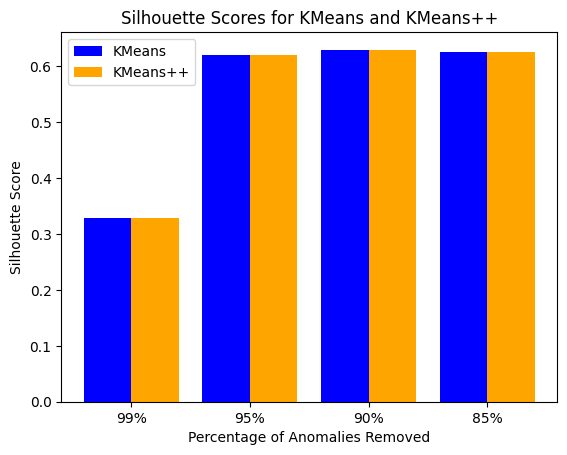

In [297]:
import matplotlib.pyplot as plt

# Data
percentages = ['99%', '95%', '90%', '85%']
kmeans_scores = [rand_sil_score_99, rand_sil_score_95, rand_sil_score_90, rand_sil_score_85]
kmeans_pp_scores = [pp_sil_score_99, pp_sil_score_95, pp_sil_score_90, pp_sil_score_85]

# X-axis positions
x = np.arange(len(percentages))

# Plot
plt.bar(x - 0.2, kmeans_scores, width=0.4, label='KMeans', color='blue')
plt.bar(x + 0.2, kmeans_pp_scores, width=0.4, label='KMeans++', color='orange')

# Add labels, title, and legend
plt.xlabel('Percentage of Anomalies Removed')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for KMeans and KMeans++')
plt.xticks(x, means)
plt.legend()

# Show plot
plt.show()



We first implemented the Kmeans and Kmeans++. We had found some articles online on how to implement both and referenced those when implementing the classifiers. One challenge that we encountered was trying to implement both Kmeans and Kmeans++ in the same classifier. We were able to eventually figure out how to implement them together into one classifier. Another issue came up when getting the silhouette scores. The silhouette score only takes in clusters that are larger than one. So, we could not calculate the scores of cluster sizes ranging from 1-5 and instead did the scores from 2-6.

To set up the models for DBSCAN and spectral clustering, we began by preprocessing the data using standardization to ensure all features were scaled uniformly, as both algorithms are sensitive to feature magnitudes. For DBSCAN, we implemented the model by defining parameters such as eps. The DBSCAN algorithm iteratively identifies core points, grows clusters, and marks noise points for clustering. we also incorporated an evaluation process by computing Silhouette Scores to measure the quality of clustering across different combinations of eps and min points. We did have trouble with eps values, we tried editing the class DBSCAN were it considers of neighbors. That showed no improvement of valuing a silhouette scoring at 0.1 and 0.2. we then tried a different scaling method and used minmaxscalar() to see how the DBSCAN improved. We kept the minmaxscalar since we saw a slight improvement with the score. In the end, we had to increase the eps values to see how efficient the clusterings were. 

For spectral clustering, we implemented the unnormalized version using a Gaussian similarity function to construct the similarity graph. The unnormalized Laplacian matrix was computed, followed by extracting the eigenvectors corresponding to the smallest eigenvalues. These eigenvectors were then passed to a custom KMeans implementation for final clustering. We further analyzed the performance of spectral clustering by varying the number of clusters and the Gaussian similarity parameter, visualizing the results with Silhouette Scores as a function of these parameters. Both methods were designed and tuned to capture meaningful clusters in the data.

For the isolation forest, it was also a challenge implementing the classifier. We also referenced a few articles as well as the paper when implementing the classifier. One challenge was trying to implement three different classifiers into one ensemble classifier. We had to make sure that they all worked together. One issue that we encountered was that the silhouette score that we were getting was abnormally low. To fix this, we tried to scale the data and use that instead. However, this further reduced the silhouette score. our reasoning is that, because we are normalizing the data, some of the important features get lost once we normalize it. We tweaked the parameters and it ended up raising the silhouette score, but something was still off. We later figured out it was a coding error, and once we debugged the code, everything worked out well.

## References

https://towardsdatascience.com/create-your-own-k-means-clustering-algorithm-in-python-d7d4c9077670

https://scrunts23.medium.com/dbscan-algorithm-from-scratch-in-python-475b82e0571c

https://scikit-learn.org/dev/modules/generated/sklearn.metrics.silhouette_samples.html

https://medium.com/@sachinsoni600517/clustering-like-a-pro-a-beginners-guide-to-dbscan-6c8274c362c4

https://medium.com/@kelvinlinBU/k-means-clustering-with-python-4b0068a47d70#:~:text=The%20K%2DMeans%20Clustering%20(AKA,the%20need%20for%20human%20supervision.

https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/

https://medium.com/@roiyeho/spectral-clustering-50aee862d300

file:///Users/joshuapulido/Downloads/s11222-007-9033-z%20(1).pdf

https://medium.com/@gallettilance/kmeans-from-scratch-24be6bee8021

https://medium.com/@kelvinlinBU/k-means-clustering-with-python-4b0068a47d70

https://medium.com/@avijit.bhattacharjee1996/implementing-k-means-clustering-from-scratch-in-python-a277c23563ac

https://towardsdatascience.com/create-your-own-k-means-clustering-algorithm-in-python-d7d4c9077670

https://towardsdatascience.com/isolation-forest-from-scratch-e7e5978e6f4c